# Imports (run once)

In [1]:
!git clone https://github.com/jldbc/pybaseball
%cd pybaseball
!pip install -e .

Cloning into 'pybaseball'...
remote: Enumerating objects: 2649, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 2649 (delta 271), reused 313 (delta 156), pack-reused 2174
Receiving objects: 100% (2649/2649), 6.72 MiB | 708.00 KiB/s, done.
Resolving deltas: 100% (1584/1584), done.
/Users/benzene/Documents/personal_code/pybaseball/pybaseball-projects/pitch_movement/pybaseball
Obtaining file:///Users/benzene/Documents/personal_code/pybaseball/pybaseball-projects/pitch_movement/pybaseball
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: pybaseball
    Found existing installation: pybaseball 2.2.5
    Uninstalling pybaseball-2.2.5:
      Successfully uninstalled pybaseball-2.2.5
  Running setup.py develop for pybaseball


I will be using the library pybaseball to obtain this data

In [2]:
from pybaseball import  statcast
from pybaseball import  statcast_pitcher
from pybaseball import cache
import pandas as pd
import numpy as np

!pip3 install seaborn
import seaborn as sns

!pip3 install plotly

import plotly.express as px

!pip3 install scikit-learn


cache.enable()

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Visualize

## 2017-2022 Data

## Create Data

In [3]:
def make_year(game_date):
    if(not game_date):
        return None
    return str(game_date)[:4]

In [19]:
data_2022 = statcast(start_dt='2018-04-06', end_dt='2022-12-31')

data_2022['game_date'] = data_2022.apply(lambda row: make_year(row['game_date']), axis=1)

# Get rates for strikeout, hbp_bb, and home_run 
data_2022['strikeout'] = np.select([(data_2022['events']=='strikeout') | (data_2022['events']=='strikeout_double_play')], [1], default=0)
data_2022['hbp_bb'] = np.select([(data_2022['events']=='walk') | (data_2022['events']=='hit_by_pitch')], [1], default=0)
data_2022['home_run'] = np.where(data_2022['events']=='home_run', 1, 0)

data_2022['count'] = data_2022['player_name'] + data_2022['pitch_type']

data_2022_strikeout_walk_home_run = data_2022[['count', 'game_date', 'player_name', 'pitch_type', 'strikeout', 'hbp_bb', 'home_run']].groupby(['game_date', 'pitch_type', 'player_name']).agg({'count' :'size', 'strikeout':'mean', 'hbp_bb':'mean', 'home_run':'mean'}).reset_index()

# Clean data to get accurate 
data_2022_clean = data_2022.loc[data_2022['pfx_x'].notnull()]
data_2022_clean = data_2022_clean.loc[data_2022_clean['pfx_z'].notnull()]
data_2022_clean = data_2022_clean.loc[data_2022_clean['launch_speed'].notnull()]
data_2022_clean = data_2022_clean.loc[data_2022_clean['release_speed'].notnull()]
data_2022_clean = data_2022_clean.loc[data_2022_clean['release_spin_rate'].notnull()]

data_2022_grouped = data_2022_clean[['count', 'game_date', 'player_name', 'pitch_type', 'pfx_x', 'pfx_z', 'launch_speed', 'release_speed', 'release_spin_rate']].groupby(['game_date', 'pitch_type', 'player_name']).agg({'count' :'size', 'pfx_x':'mean', 'pfx_z':'mean', 'launch_speed':'mean', 'release_speed':'mean', 'release_spin_rate':'mean'}).reset_index()

# Round launch speed to make it more readable
data_2022_grouped['launch_speed'] = data_2022_grouped['launch_speed'].round(1)
data_2022_grouped['release_speed'] = data_2022_grouped['release_speed'].round(1)

# Get total movement
data_2022_grouped['total_movement'] = (data_2022_grouped['pfx_x'].pow(2) + data_2022_grouped['pfx_z'].pow(2)).pow(.5)

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 1020/1020 [04:15<00:00,  3.99it/s]


In [20]:
# Merge two dataframes together
df_final_by_pitch = data_2022_grouped.merge(data_2022_strikeout_walk_home_run, how='left', on=['game_date', 'pitch_type', 'player_name'])
df_final_by_pitch.loc['mean'] = df_final_by_pitch.mean()
df_final_by_pitch['player_name']['mean'] = 'Average'

df_final_by_pitch

/var/folders/yx/y4gd7hgd2hn9r_s2pcv1k7lc0000gn/T/ipykernel_2381/2862156498.py:3: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/yx/y4gd7hgd2hn9r_s2pcv1k7lc0000gn/T/ipykernel_2381/2862156498.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



game_date pitch_type        player_name   count_x     pfx_x     pfx_z  \
0          2018         CH        Adam, Jason   15.0000    -1.198  0.332667   
1          2018         CH       Albers, Matt   18.0000 -1.171111  0.190556   
2          2018         CH   Alcantara, Sandy   19.0000 -1.192632  0.446842   
3          2018         CH  Alcántara, Victor   21.0000  -1.32381  0.671905   
4          2018         CH   Alexander, Scott   12.0000    1.2475  0.164167   
...         ...        ...                ...       ...       ...       ...   
16534      2022         SV      Berríos, José  235.0000  1.294255  -0.31183   
16535      2022         SV       McKay, David   13.0000      1.19 -0.688462   
16536      2022         SV    Stroman, Marcus  133.0000  1.180752  0.012857   
16537      2022         SV       Urías, Julio  333.0000 -1.352192 -0.076577   
mean        inf        NaN            Average   58.4249 -0.150786  0.517812   

       launch_speed  release_speed  release_spin_rate  total_movement  \
0              79.1           89.2        1906.333333        1.243331   
1              74.2           83.4        1403.055556        1.186513   
2              82.6           88.9        1785.315789        1.273593   
3              77.7           88.0        1736.333333        1.484563   
4              81.0           86.2        1674.333333        1.258256   
...             ...            ...                ...             ...   
16534          80.5           83.1        2278.714894        1.331291   
16535          80.0           77.5        2750.153846        1.374802   
16536          81.4           84.7        2655.150376        1.180822   
16537          79.0           81.2        2926.051051        1.354359   
mean      82.724368      86.952806        2188.100943        1.168516   

          count_y  strikeout    hbp_bb  home_run  
0       45.000000   0.022222  0.000000  0.022222  
1       73.000000   0.013699  0.000000  0.000000  
2       72.000000   0.097222  0.013889  0.013889  
3       83.000000   0.096386  0.012048  0.012048  
4       36.000000   0.083333  0.027778  0.000000  
...           ...        ...       ...       ...  
16534  873.000000   0.077892  0.014891  0.009164  
16535   34.000000   0.058824  0.000000  0.029412  
16536  518.000000   0.057915  0.005792  0.001931  
16537  930.000000   0.065591  0.013978  0.009677  
mean   194.030475   0.051050  0.023499  0.010312  

[16539 rows x 14 columns]

## Visualize data

In [21]:
# Tweak count to get rid of pitches with low data (Pitches must have been thrown 70 times)
pitch_data = df_final_by_pitch.loc[df_final_by_pitch['count_y'] >= 70]

Experiment with movement and average exit velo. Size of Dot is percentile of exit velocity (Bigger is worse)

In [22]:
launch_list=(100 * (pitch_data['launch_speed']-pitch_data['launch_speed'].min())/(pitch_data['launch_speed'].max()-pitch_data['launch_speed'].min())).round(2).to_list()
fig = px.scatter(pitch_data, x='pfx_x', y='pfx_z', color='pitch_type', size=launch_list, hover_data=['player_name', 'pitch_type', 'game_date', 'launch_speed'], title='2018-2022 movement and Launch speed(size)' )

fig.add_hline(y=pitch_data['pfx_z'].mean(), line_dash='dash')
fig.add_vline(x=pitch_data['pfx_x'].mean(), line_dash='dash')

fig.show()

Experiment with movement and strikeout rate. Size of Dot is percentile of strikeout rate (Bigger is better)

In [23]:
strikeout_list=(100 * (pitch_data['strikeout']-pitch_data['strikeout'].min())/(pitch_data['strikeout'].max()-pitch_data['strikeout'].min())).round(2).to_list()
fig = px.scatter(pitch_data, x='pfx_x', y='pfx_z', color='pitch_type', size=strikeout_list, hover_data=['player_name', 'pitch_type', 'game_date', 'strikeout', 'count_y'], title='2018-2022 movement and Strikeout rate (size)' )

fig.add_hline(y=pitch_data['pfx_z'].mean(), line_dash='dash')
fig.add_vline(x=pitch_data['pfx_x'].mean(), line_dash='dash')

fig.show()

Experiment with movement and walk/hbp rate. Size of Dot is percentile of walk/hbp rate (Bigger is worse)

In [24]:
walk_list=(100 * (pitch_data['hbp_bb']-pitch_data['hbp_bb'].min())/(pitch_data['hbp_bb'].max()-pitch_data['hbp_bb'].min())).round(2).to_list()
fig = px.scatter(pitch_data, x='pfx_x', y='pfx_z', color='pitch_type', size=walk_list, hover_data=['player_name', 'pitch_type', 'game_date', 'hbp_bb', 'count_y'], title='2018-2022 movement and Walk rate (size)' )

fig.add_hline(y=pitch_data['pfx_z'].mean(), line_dash='dash')
fig.add_vline(x=pitch_data['pfx_x'].mean(), line_dash='dash')

fig.show()

Experiment with movement and home run rate. Size of Dot is percentile of home run rate (Bigger is worse)

In [25]:
home_run_list=(100 * (pitch_data['home_run']-pitch_data['home_run'].min())/(pitch_data['home_run'].max()-pitch_data['home_run'].min())).round(2).to_list()
fig = px.scatter(pitch_data, x='pfx_x', y='pfx_z', color='pitch_type', size=home_run_list, hover_data=['player_name', 'pitch_type', 'game_date', 'home_run', 'count_y'], title='2018-2022 movement and Home Run rate (size)' )

fig.add_hline(y=pitch_data['pfx_z'].mean(), line_dash='dash')
fig.add_vline(x=pitch_data['pfx_x'].mean(), line_dash='dash')

fig.show()

In [26]:
fig = px.scatter(pitch_data, x='pfx_x', y='pfx_z', color='release_speed', hover_data=['player_name', 'pitch_type', 'game_date', 'count_y'], title='2018-2022 Movement and Velocity (color)' )

fig.add_hline(y=pitch_data['pfx_z'].mean(), line_dash='dash')
fig.add_vline(x=pitch_data['pfx_x'].mean(), line_dash='dash')

fig.show()

Now we will take this data we have visualized and try to use machine learning to learn from it

/var/folders/yx/y4gd7hgd2hn9r_s2pcv1k7lc0000gn/T/ipykernel_2381/3263535506.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yx/y4gd7hgd2hn9r_s2pcv1k7lc0000gn/T/ipykernel_2381/3263535506.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yx/y4gd7hgd2hn9r_s2pcv1k7lc0000gn/T/ipykernel_2381/3263535506.py:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value 

<AxesSubplot: >

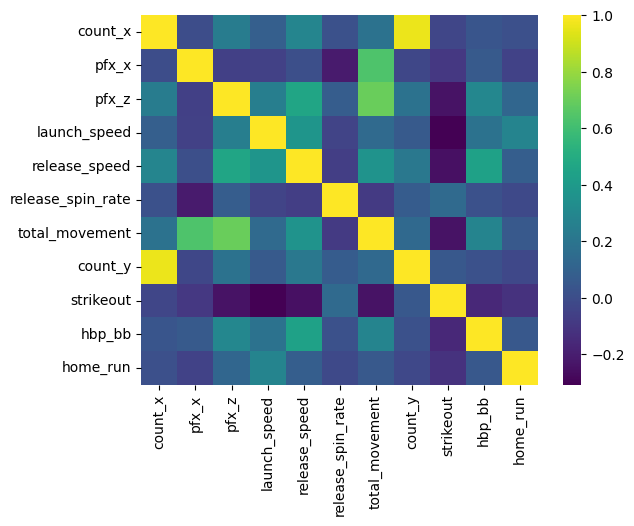

In [16]:
# Correlation
# Take Absolute value of pitch movement
pitch_data['pfx_x'] = abs(pitch_data['pfx_x'])
pitch_data['pfx_z'] = abs(pitch_data['pfx_z'])
corr = pitch_data.corr()

sns.heatmap(corr, cmap='viridis')

# Machine Learning

## Make new data
Only keep things we are going to use and one hot enocde pitch_type

In [18]:
pitch_data_ml = pitch_data.drop([ 'game_date', 'player_name', 'count_x', 'count_y'], axis=1)

pitch_data_ml = pd.get_dummies(pitch_data_ml)
pitch_data_ml

pfx_x     pfx_z  launch_speed  release_speed  release_spin_rate  \
1      1.171111  0.190556          74.2           83.4        1403.055556   
2      1.192632  0.446842          82.6           88.9        1785.315789   
3       1.32381  0.671905          77.7           88.0        1736.333333   
8      1.175806  0.539355          75.5           81.1        1925.064516   
9      1.154265  0.748824          84.5           83.6        1561.558824   
...         ...       ...           ...            ...                ...   
16528   1.39129  0.269355          83.1           81.7        2774.096774   
16529  1.294255   0.31183          80.5           83.1        2278.714894   
16531  1.180752  0.012857          81.4           84.7        2655.150376   
16532  1.352192  0.076577          79.0           81.2        2926.051051   
mean   0.150818  0.517984     82.723807      86.952864        2188.121392   

       total_movement  strikeout    hbp_bb  home_run  pitch_type_CH  ...  \
1            1.186513   0.013699  0.000000  0.000000              1  ...   
2            1.273593   0.097222  0.013889  0.013889              1  ...   
3            1.484563   0.096386  0.012048  0.012048              1  ...   
8            1.293609   0.071942  0.035971  0.000000              1  ...   
9            1.375887   0.030043  0.004292  0.017167              1  ...   
...               ...        ...       ...       ...            ...  ...   
16528        1.417124   0.056911  0.048780  0.016260              0  ...   
16529        1.331291   0.077892  0.014891  0.009164              0  ...   
16531        1.180822   0.057915  0.005792  0.001931              0  ...   
16532        1.354359   0.065591  0.013978  0.009677              0  ...   
mean         1.168488   0.051060  0.023493  0.010331              0  ...   

       pitch_type_FC  pitch_type_FF  pitch_type_FO  pitch_type_FS  \
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
8                  0              0              0              0   
9                  0              0              0              0   
...              ...            ...            ...            ...   
16528              0              0              0              0   
16529              0              0              0              0   
16531              0              0              0              0   
16532              0              0              0              0   
mean               0              0              0              0   

       pitch_type_KC  pitch_type_KN  pitch_type_SI  pitch_type_SL  \
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
8                  0              0              0              0   
9                  0              0              0              0   
...              ...            ...            ...            ...   
16528              0              0              0              0   
16529              0              0              0              0   
16531              0              0              0              0   
16532              0              0              0              0   
mean               0              0              0              0   

       pitch_type_ST  pitch_type_SV  
1                  0              0  
2                  0              0  
3                  0              0  
8                  0              0  
9                  0              0  
...              ...            ...  
16528              1              0  
16529              0              1  
16531              0              1  
16532              0              1  
mean               0              0  

[9488 rows x 24 columns]

## I do not have a GPU :( so I will be using google colab for this section

In [19]:
pitch_data_ml.to_csv('/Users/benzene/Documents/personal_code/pybaseball/pitch_movement_2022/pitch_data_clean.csv')